# 1. Import Library

In [1]:
import os, shutil, random, hashlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 2. Path Config

In [2]:
ROOT_DATA = '/content/drive/MyDrive/Dataset'
RAW_HAMA = os.path.join(ROOT_DATA, 'Data Sawi Ada Hama')
RAW_NO   = os.path.join(ROOT_DATA, 'Data Sawi Tanpa Hama')

SPLIT_DIR = '/content/dataset_split'
TRAIN_DIR = os.path.join(SPLIT_DIR, 'train')
VAL_DIR   = os.path.join(SPLIT_DIR, 'val')

MODEL_SAVE = '/content/drive/MyDrive/saved_sawi_models'
os.makedirs(MODEL_SAVE, exist_ok=True)
ROOT_DATA = '/content/drive/MyDrive/Dataset'
RAW_HAMA = os.path.join(ROOT_DATA, 'Data Sawi Ada Hama')
RAW_NO   = os.path.join(ROOT_DATA, 'Data Sawi Tanpa Hama')

SPLIT_DIR = '/content/dataset_split'
TRAIN_DIR = os.path.join(SPLIT_DIR, 'train')
VAL_DIR   = os.path.join(SPLIT_DIR, 'val')

MODEL_SAVE = '/content/drive/MyDrive/saved_sawi_models'
os.makedirs(MODEL_SAVE, exist_ok=True)

# 3. Reset Split Directory

In [3]:
shutil.rmtree(SPLIT_DIR, ignore_errors=True)
for d in [TRAIN_DIR, VAL_DIR]:
    os.makedirs(os.path.join(d, 'with_pest'), exist_ok=True)
    os.makedirs(os.path.join(d, 'without_pest'), exist_ok=True)

# 4. Data Preprocessing

## 4.1 HELPER FUNCTIONS

In [4]:
def collect_images(folder):
    imgs = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(('.jpg','.jpeg','.png','.webp')):
                imgs.append(os.path.join(root, f))
    return imgs

def remove_corrupt(files):
    clean = []
    for f in files:
        try:
            Image.open(f).verify()
            clean.append(f)
        except:
            os.remove(f)
    return clean

def remove_duplicates(files):
    seen, uniq = {}, []
    for f in files:
        with open(f,'rb') as img:
            h = hashlib.md5(img.read()).hexdigest()
        if h not in seen:
            seen[h] = f
            uniq.append(f)
        else:
            os.remove(f)
    return uniq

def split_copy(files, label):
    random.shuffle(files)
    split = int(0.8 * len(files))
    train, val = files[:split], files[split:]
    for f in train:
        shutil.copy(f, os.path.join(TRAIN_DIR, label, os.path.basename(f)))
    for f in val:
        shutil.copy(f, os.path.join(VAL_DIR, label, os.path.basename(f)))
    print(f"{label}: Train={len(train)} | Val={len(val)}")

## 4.2 Data Cleaning

In [5]:
print("\n--- Data Cleaning ---")
hama_imgs = remove_duplicates(remove_corrupt(collect_images(RAW_HAMA)))
no_imgs   = remove_duplicates(remove_corrupt(collect_images(RAW_NO)))

print("Ada Hama:", len(hama_imgs))
print("Tanpa Hama:", len(no_imgs))


--- Data Cleaning ---
Ada Hama: 565
Tanpa Hama: 500


# 5. Data Split

In [6]:
print("\n--- Split 80:20 ---")
split_copy(hama_imgs, 'with_pest')
split_copy(no_imgs, 'without_pest')


--- Split 80:20 ---
with_pest: Train=452 | Val=113
without_pest: Train=400 | Val=100


# 6. Exploratory Data Analysis



--- EDA ---
with_pest train: 407
without_pest train: 400

Sample: with_pest


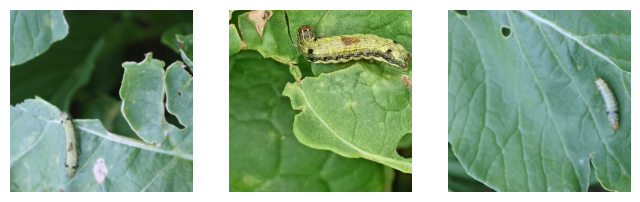


Sample: without_pest


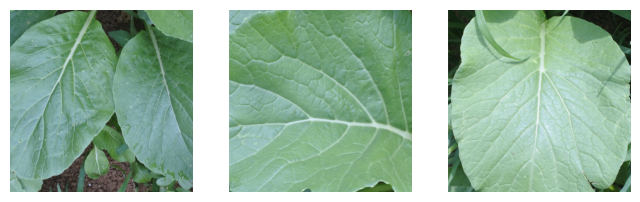

In [7]:
print("\n--- EDA ---")
for cls in ['with_pest','without_pest']:
    print(cls, "train:", len(os.listdir(os.path.join(TRAIN_DIR,cls))))

def show_samples(dirpath):
    for cls in ['with_pest','without_pest']:
        imgs = os.listdir(os.path.join(dirpath,cls))
        samples = random.sample(imgs, min(3,len(imgs)))
        plt.figure(figsize=(8,3))
        print("\nSample:",cls)
        for i,img in enumerate(samples):
            plt.subplot(1,3,i+1)
            plt.imshow(Image.open(os.path.join(dirpath,cls,img)))
            plt.axis('off')
        plt.show()

show_samples(TRAIN_DIR)

# 7. Modelling

## 7.1 Data Generator

In [8]:
IMG_SIZE=(224,224)
BATCH=8
EPOCHS=20

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True
).flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE,
    batch_size=BATCH, class_mode='binary'
)

val_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE,
    batch_size=BATCH, class_mode='binary', shuffle=False
)

Found 807 images belonging to 2 classes.
Found 209 images belonging to 2 classes.


## 7.2 Model NASNetMobile Implementation

In [9]:
base = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(base.input, out)
model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3)
]

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 8. Model Training

In [10]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 79s 626ms/step - accuracy: 0.6474 - loss: 0.7466 - val_accuracy: 0.9426 - val_loss: 0.3091 - learning_rate: 1.0000e-04
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 57s 568ms/step - accuracy: 0.8276 - loss: 0.4016 - val_accuracy: 0.9378 - val_loss: 0.1892 - learning_rate: 1.0000e-04
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 58s 573ms/step - accuracy: 0.8762 - loss: 0.3214 - val_accuracy: 0.9378 - val_loss: 0.1404 - learning_rate: 1.0000e-04
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 58s 571ms/step - accuracy: 0.8582 - loss: 0.3383 - val_accuracy: 0.9474 - val_loss: 0.1279 - learning_rate: 1.0000e-04
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 56s 559ms/step - accuracy: 0.8712 - loss: 0.2818 - val_accuracy: 0.9474 - val_loss: 0.1299 - learning_rate: 1.0000e-04
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 58s 571ms/step - accuracy: 0.8874 - loss: 0.2673 - val_accuracy: 0.9426 - val_loss: 0.1278 - learning_rate: 1.0000e-04
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 67s 66

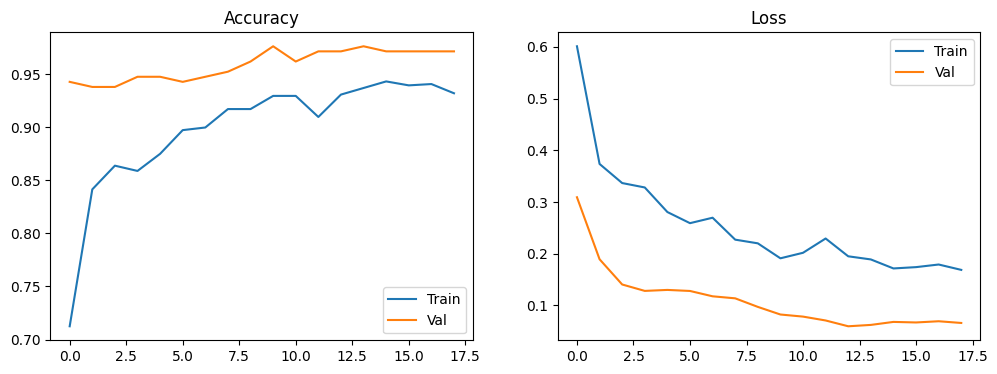

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['Train','Val'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['Train','Val'])
plt.show()

# 9. Model Validation

27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 562ms/step


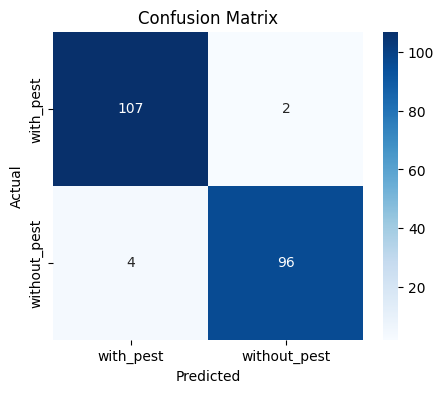


Classification Report:

              precision    recall  f1-score   support

   with_pest       0.96      0.98      0.97       109
without_pest       0.98      0.96      0.97       100

    accuracy                           0.97       209
   macro avg       0.97      0.97      0.97       209
weighted avg       0.97      0.97      0.97       209



In [12]:
# CONFUSION MATRIX
val_gen.reset()
preds = (model.predict(val_gen) > 0.5).astype(int).ravel()
y_true = val_gen.classes

cm = confusion_matrix(y_true, preds)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d',
    cmap='Blues',
    xticklabels=['with_pest','without_pest'],
    yticklabels=['with_pest','without_pest']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# CLASSIFICATION REPORT
print("\nClassification Report:\n")
print(classification_report(
    y_true, preds,
    target_names=['with_pest','without_pest']
))

# 10. Save Model (.h5)


In [13]:
model_path = os.path.join(MODEL_SAVE, 'NASNetMobile_Sawi_Final.h5')
model.save(model_path)
print("\nModel saved to:", model_path)


Model saved to: /content/drive/MyDrive/saved_sawi_models/NASNetMobile_Sawi_Final.h5
